# Skin Tone Classification



In [1]:
# Random seed to get similar results

from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

In [2]:
# Mounting Google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# unzip test file
'!unzip -u "/content/drive/MyDrive/Face tone_Training/training_images.zip" -d "/content/drive/MyDrive/Face tone_Training"

SyntaxError: ignored

In [5]:
import time
import math
import random

import dlib
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

import os
import glob

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from datetime import timedelta

%matplotlib inline

## Configuration and Hyperparameters

In [17]:
# Convolutional Layer 1.
filter_size1 = 3 
num_filters1 = 32

# Convolutional Layer 2.
filter_size2 = 3
num_filters2 = 32

# Convolutional Layer 3.
filter_size3 = 3
num_filters3 = 64

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

# Number of color channels for the images: 1 channel for gray-scale.
num_channels = 3

# image dimensions (only squares for now)
img_size = 128

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# class info
classes = ['01 light', '02 medium', '03 dark']
num_classes = len(classes)

# batch size
batch_size = 32

# validation split
validation_size = .16

# how long to wait after validation loss stops improving before terminating training
early_stopping = None  # use None if you don't want to implement early stoping


# copy and paste paths from drive for both training and testing data

train_path = '/content/drive/MyDrive/Face tone_Training/training_images'
test_path = '/content/drive/MyDrive/Face tone_Training/testing_images'
checkpoint_dir = "models/"

In [48]:
# Dataset Functions

def load_train(train_path, image_size, classes):
    images = []
    labels = []
    ids = []
    cls = []

    print('Reading training images')
    for fld in classes:  # assuming data directory has a separate folder for each class, and that each folder is named after the class
        index = classes.index(fld)
        print('Loading {} files (Index: {})'.format(fld, index))
        path = os.path.join(train_path, fld, '*g')
        files = glob.glob(path)
        for fl in files:

            try:
              image = cv2.imread(fl)

              # Face Cropping to train an efficient model that focuses on the face and not the background
              gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
              _face_detector = dlib.get_frontal_face_detector()
              faces = _face_detector(gray)
              d = faces[0]
              image = cv2.resize(image[d.top():d.bottom(),d.left():d.right()], (image_size, image_size), cv2.INTER_LINEAR)

              images.append(image)
              label = np.zeros(len(classes))
              label[index] = 1.0
              labels.append(label)
              flbase = os.path.basename(fl)
              ids.append(flbase)
              cls.append(fld)

            except Exception as e:
              print(str(e))
    images = np.array(images)
    labels = np.array(labels)
    ids = np.array(ids)
    cls = np.array(cls)

    return images, labels, ids, cls


def load_test(test_path, image_size):
    path = os.path.join(test_path, '*g')
    files = sorted(glob.glob(path))

    X_test = []
    X_test_id = []
    print("Reading test images")
    for fl in files:
        flbase = os.path.basename(fl)
        img = cv2.imread(fl)
        img = cv2.resize(img, (image_size, image_size), cv2.INTER_LINEAR)

        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        _face_detector = dlib.get_frontal_face_detector()
        faces = _face_detector(gray)
        d = faces[0]
        img = cv2.resize(img[d.top():d.bottom(),d.left():d.right()], (img_size, img_size), cv2.INTER_LINEAR)

        X_test.append(img)
        X_test_id.append(flbase)

    ### because we're not creating a DataSet object for the test images, normalization happens here
    X_test = np.array(X_test, dtype=np.uint8)
    X_test = X_test.astype('float32')
    X_test = X_test

    return X_test, X_test_id


class DataSet(object):

    def __init__(self, images, labels, ids, cls):
        """Construct a DataSet. one_hot arg is used only if fake_data is true."""

        self._num_examples = images.shape[0]

        # Convert shape from [num examples, rows, columns, depth]
        # to [num examples, rows*columns] (assuming depth == 1)
        # Convert from [0, 255] -> [0.0, 1.0].

        images = images.astype(np.float32)
        images = np.multiply(images, 1.0 / 255.0)

        self._images = images
        self._labels = labels
        self._ids = ids
        self._cls = cls
        self._epochs_completed = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def ids(self):
        return self._ids

    @property
    def cls(self):
        return self._cls

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_completed(self):
        return self._epochs_completed

    def next_batch(self, batch_size):
        """Return the next `batch_size` examples from this data set."""
        start = self._index_in_epoch
        self._index_in_epoch += batch_size

        if self._index_in_epoch > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1

            # # Shuffle the data (maybe)
            # perm = np.arange(self._num_examples)
            # np.random.shuffle(perm)
            # self._images = self._images[perm]
            # self._labels = self._labels[perm]
            # Start next epoch

            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch

        return self._images[start:end], self._labels[start:end], self._ids[start:end], self._cls[start:end]


def read_train_sets(train_path, image_size, classes, validation_size=0):
    class DataSets(object):
        pass

    data_sets = DataSets()

    images, labels, ids, cls = load_train(train_path, image_size, classes)
    images, labels, ids, cls = shuffle(images, labels, ids, cls)  # shuffle the data

    if isinstance(validation_size, float):
        validation_size = int(validation_size * images.shape[0])

    validation_images = images[:validation_size]
    validation_labels = labels[:validation_size]
    validation_ids = ids[:validation_size]
    validation_cls = cls[:validation_size]

    train_images = images[validation_size:]
    train_labels = labels[validation_size:]
    train_ids = ids[validation_size:]
    train_cls = cls[validation_size:]

    data_sets.train = DataSet(train_images, train_labels, train_ids, train_cls)
    data_sets.valid = DataSet(validation_images, validation_labels, validation_ids, validation_cls)

    return data_sets


def read_test_set(test_path, image_size):
    images, ids = load_test(test_path, image_size)
    return images, ids

## Load Data

In [49]:
data = read_train_sets(train_path, img_size, classes, validation_size=validation_size)

Reading training images
Loading 01 light files (Index: 0)







Loading 02 medium files (Index: 1)
OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'













OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Loading 03 dark files (Index: 2)








OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'








OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [50]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Validation-set:\t{}".format(len(data.valid.labels)))

Size of:
- Training-set:		1913
- Validation-set:	364


In [51]:
# We have almost 1400 white samples, 400 medium samples and 400 black samples, to tackle biasness, we have to assign class weights to the model

classWeights = {0: 0.83, 1: 1.84, 2: 1.44}

### Function for plotting images

Function used to plot 9 images in a 3x3 grid and writing the true and predicted classes below each image.

In [52]:
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
    if cls_pred is not None:
        images, cls_true, cls_pred  = zip(*[(images[i], cls_true[i], cls_pred[i]) for i in random_indices])
    else:
        images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(14, 12))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        ax.imshow(np.array(image))

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

array([[[0.00218378, 0.00287582, 0.00309112],
        [0.00230681, 0.00299885, 0.00319877],
        [0.00250673, 0.00318339, 0.00339869],
        ...,
        [0.00150711, 0.00198385, 0.00236832],
        [0.00110727, 0.00161476, 0.00199923],
        [0.00087659, 0.00138408, 0.00176855]],

       [[0.00230681, 0.00299885, 0.00322953],
        [0.00233756, 0.00304498, 0.00327566],
        [0.00239908, 0.0031065 , 0.00335256],
        ...,
        [0.00158401, 0.00207612, 0.00242983],
        [0.00121492, 0.00169166, 0.00207612],
        [0.00098424, 0.00146098, 0.00184544]],

       [[0.00250673, 0.00322953, 0.00347559],
        [0.00239908, 0.00313726, 0.00339869],
        [0.00222991, 0.00299885, 0.00326028],
        ...,
        [0.00172241, 0.00221453, 0.00253749],
        [0.0013687 , 0.00181469, 0.00219915],
        [0.0011534 , 0.00158401, 0.00198385]],

       ...,

       [[0.00286044, 0.00339869, 0.00361399],
        [0.00262976, 0.00318339, 0.00349097],
        [0.00222991, 0

### Plotting a few images randomly to check if data is correct




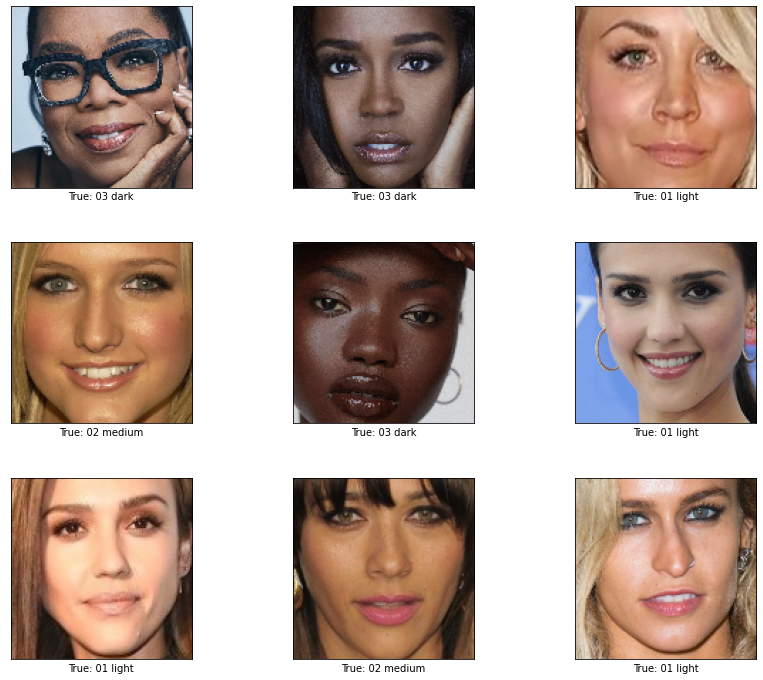

In [54]:
# Get some random images and their labels from the train set.

images, cls_true  = data.train.images, data.train.cls

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

### Model Architecture for Image Classification

In [88]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(num_filters1, filter_size1, activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.04),
                           input_shape=(img_size, img_size, num_channels)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(num_filters2, filter_size2, activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.04)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(num_filters3, filter_size3, activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.04)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(fc_size, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

## TensorFlow Run

In [89]:
train_batch_size = batch_size

In [90]:
def print_progress(epoch, train_acc, train_loss, val_acc, val_loss):
    msg = f"Epoch {epoch} --- Training Accuracy: {train_acc:>6.1%}, Validation Accuracy: {val_acc:>6.1%}, Training Loss: {train_loss:.3f}, Validation Loss: {val_loss:.3f}"
    print(msg)

Function for performing a number of optimization iterations so as to gradually improve the variables of the network layers. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.  The progress is printed every 100 iterations.

In [91]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def train(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations
    t_loss = []
    v_loss = []
    t_acc = []
    v_acc = []
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    best_val_loss = float("inf")
    patience = 0

    for i in range(total_iterations, total_iterations + num_iterations):
        # Reset the metric accumulators
        model.reset_metrics()

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch, _, cls_batch = data.train.next_batch(train_batch_size)
        x_valid_batch, y_valid_batch, _, valid_cls_batch = data.valid.next_batch(train_batch_size)

        train_loss, train_acc = model.train_on_batch(x_batch, y_true_batch, reset_metrics=False, class_weight = classWeights) 
        
        
      

        # Print status at end of each epoch (defined as full pass through training dataset).
        if i % int(data.train.num_examples/batch_size) == 0: 
            val_loss, val_acc = model.test_on_batch(x_valid_batch, y_valid_batch, reset_metrics=False)
            
            t_loss.append(train_loss)
            t_acc.append(train_acc)
            v_loss.append(val_loss)
            v_acc.append(val_acc)

            epoch = int(i / int(data.train.num_examples/batch_size))
            metrics_names = model.metrics_names
            
            print_progress(epoch, train_acc, train_loss, val_acc, val_loss)
            
            if early_stopping:    
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience = 0
                else:
                    patience += 1

                if patience == early_stopping:
                    break

    # Training and Validation Loss Graphs

    figure = plt.gcf()
    figure.set_size_inches(6, 5)
    plt.plot(np.arange(0,len(t_loss)), t_loss, 'go-')
    plt.plot(np.arange(0,len(v_loss)), v_loss, 'bo-')

    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()


    
    # Training and Validation Accuracy Graphs

    figure = plt.gcf()
    figure.set_size_inches(6, 5)
    plt.plot(np.arange(0,len(t_acc)), t_acc, 'go-')
    plt.plot(np.arange(0,len(v_acc)), v_acc, 'bo-')

    plt.title('Model Accuracy')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
       

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))

### Helper-function to plot example errors

Function for plotting examples of images from the test-set that have been mis-classified.

In [92]:
def plot_example_errors(cls_pred, correct):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.valid.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.valid.cls[incorrect]

    # Plot the first 9 images.
    plot_images(images=images, cls_true=cls_true, cls_pred=cls_pred)

### Helper-function to plot confusion matrix

In [93]:
def plot_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.valid.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Function to print Classification Accuracy on Validation Set

---



In [94]:
def print_validation_accuracy(show_example_errors=False, show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.valid.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.valid.images[i:j, :]
        

        # Get the associated labels.
        labels = data.valid.labels[i:j, :]

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = np.argmax(model(images), 1)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    cls_true = np.array(data.valid.cls)
    cls_pred = np.array([classes[x] for x in cls_pred]) 

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Validation-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Performance after 900 optimization iteration

Epoch 0 --- Training Accuracy:  65.6%, Validation Accuracy:  60.9%, Training Loss: 4.380, Validation Loss: 4.270
Epoch 1 --- Training Accuracy:  75.0%, Validation Accuracy:  75.0%, Training Loss: 3.622, Validation Loss: 3.538
Epoch 2 --- Training Accuracy:  68.8%, Validation Accuracy:  75.0%, Training Loss: 3.179, Validation Loss: 3.101
Epoch 3 --- Training Accuracy:  81.2%, Validation Accuracy:  79.7%, Training Loss: 2.940, Validation Loss: 2.858
Epoch 4 --- Training Accuracy:  84.4%, Validation Accuracy:  81.2%, Training Loss: 2.769, Validation Loss: 2.648
Epoch 5 --- Training Accuracy:  84.4%, Validation Accuracy:  85.9%, Training Loss: 2.611, Validation Loss: 2.471
Epoch 6 --- Training Accuracy:  84.4%, Validation Accuracy:  81.2%, Training Loss: 2.429, Validation Loss: 2.327
Epoch 7 --- Training Accuracy:  75.0%, Validation Accuracy:  85.9%, Training Loss: 2.269, Validation Loss: 2.112
Epoch 8 --- Training Accuracy:  71.9%, Validation Accuracy:  79.7%, Training Loss: 2.156, Valida

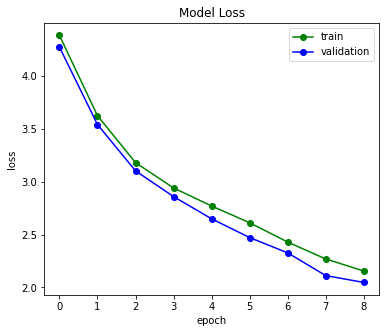

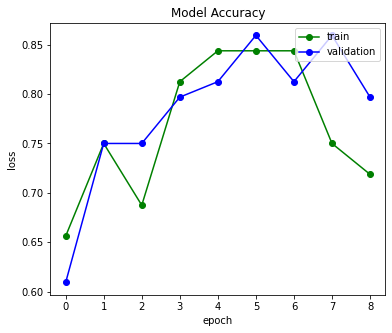

Time elapsed: 0:04:57
Accuracy on Validation-Set: 83.5% (304 / 364)


In [95]:
train(num_iterations=500)
print_validation_accuracy()

Accuracy on Validation-Set: 83.5% (304 / 364)
Example errors:


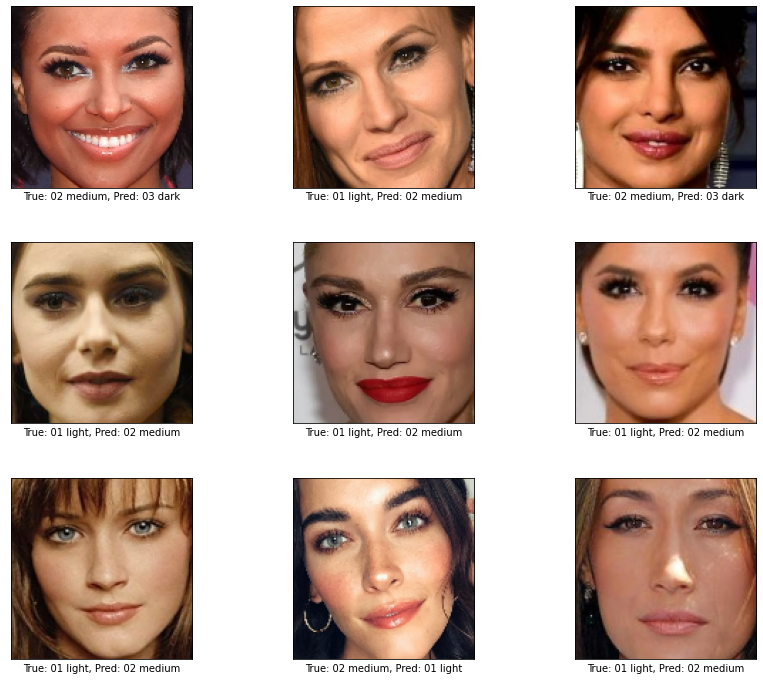

In [96]:
print_validation_accuracy(show_example_errors=True)

## Confusion Matrix

Accuracy on Validation-Set: 83.5% (304 / 364)
Example errors:


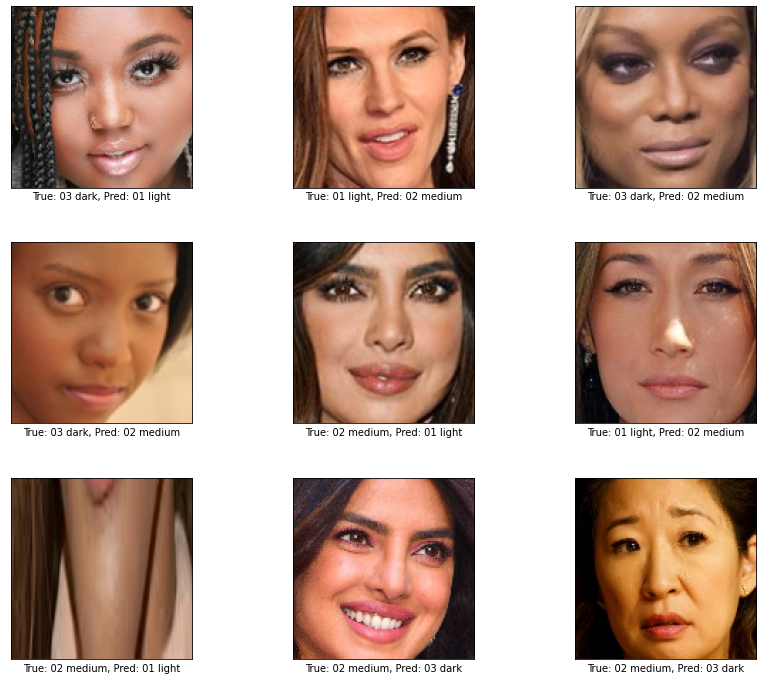

Confusion Matrix:
[[220  20   2]
 [ 23  40   7]
 [  2   6  44]]


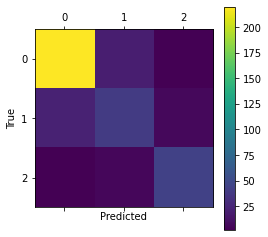

In [97]:
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

## Test on Sample Image

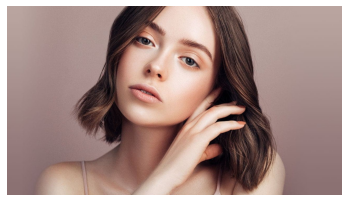

In [98]:
plt.axis('off')

test_img1 = cv2.imread('/content/drive/MyDrive/Face tone_Training/testing_images/T001.jpg')

plt.imshow(cv2.cvtColor(test_img1, cv2.COLOR_BGR2RGB))
plt.show()

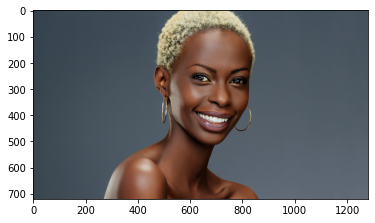

In [99]:
test_img2 = cv2.imread('/content/drive/MyDrive/Face tone_Training/testing_images/T002.jpg')

plt.imshow(cv2.cvtColor(test_img2, cv2.COLOR_BGR2RGB))
plt.show()

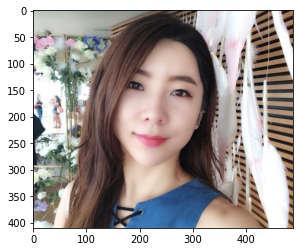

In [100]:
test_img3 = cv2.imread('/content/drive/MyDrive/Face tone_Training/testing_images/T003.jpg')

plt.imshow(cv2.cvtColor(test_img3, cv2.COLOR_BGR2RGB))
plt.show()

In [103]:
def sample_prediction(test_im):
    gray = cv2.cvtColor(test_im, cv2.COLOR_RGB2GRAY)
    _face_detector = dlib.get_frontal_face_detector()
    faces = _face_detector(gray)
    d = faces[0]
    test_im = cv2.resize(test_im[d.top():d.bottom(),d.left():d.right()], (img_size, img_size), cv2.INTER_LINEAR)/255

    test_pred = np.argmax(model(test_im.reshape((1, img_size, img_size, 3))))
    return classes[test_pred]

print("Predicted class for test_img1: {}".format(sample_prediction(test_img1)))
print("Predicted class for test_img2: {}".format(sample_prediction(test_img2)))
print("Predicted class for test_img3: {}".format(sample_prediction(test_img3)))

Predicted class for test_img1: 01 light
Predicted class for test_img2: 03 dark
Predicted class for test_img3: 01 light


In [104]:
# Saving the model

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")